## Objective

The objective of this machine learning project is to develop a robust Hindi-to-English translation model using deep learning techniques. The primary goal is to improve the translation quality for real-time news articles and informational content sourced from various Indian news websites. The model aims to handle the nuances of the Hindi language effectively and produce translations that maintain the contextual and cultural accuracy of the original text.

In [1]:
# Standard libraries
import multiprocessing
import re
import string
from string import digits
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Data manipulation and numerical libraries
import numpy as np
import pandas as pd

# Natural Language Processing (NLP)
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# Machine Learning and data processing libraries
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

# Deep Learning frameworks and utilities
import tensorflow as tf
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import MarianMTModel, MarianTokenizer, Seq2SeqTrainer, Seq2SeqTrainingArguments, GenerationConfig

# Display settings for pandas
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 250)

# Configure warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", message="Some non-default generation parameters")

In [2]:
# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     /home/bruisedwolf/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/bruisedwolf/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/bruisedwolf/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
# Reading the web-scrapped csv file
df = pd.read_csv("./language.csv")
df = shuffle(df).reset_index(drop=True)
df.head(n=10)

,Reference,Hindi,English
0,https://www.bhaskar.com/local/mp/indore/,रिहायशी मकान से अलग-अलग ब्रांड की हाईरेंज विदेशी शराब जब्त: इंदौर में दो दिन में अवैध शराब के केस; चुनावी मौसम में सप्लायर सक्रिय,Foreign liquor of different brands from residential houses seized: Illegal liquor cases in two days in Indore;Suppliers active in election season
1,https://navbharattimes.indiatimes.com/web-stories/photolist/75432298.cms,जानें क्‍या हैं सब्‍जा सीड्स के फायदे,Learn what are the benefits of vegetable seeds
2,https://www.jansatta.com/entertainment/krk-urf-kamal-rashid-khan-reaction-on-bollywood-actor-salman-khan-gunshot-outside-bandra-home/3309361/,फिल्म क्रिटिक्स और बॉलीवुड एक्टर कमाल राशिद खान ने हाल ही में ट्वीट करते हुए सलमान खान के घर के बाहर हुई फायरिंग को ड्रामा बताया है।,Film Critics and Bollywood actor Kamal Rashid Khan recently tweeted the firing outside Salman Khan's house as a drama.
3,https://navbharattimes.indiatimes.com/state/goa/articlelist/92681993.cms,"न्यू ईयर की आतिशबाजी में इटली के राजदूत की पत्नी हुई घायल, गोवा पुलिस ने रिसॉर्ट मालिक के खिलाफ दर्ज की","Italy's wife injured in New Year fireworks, Goa police registered against resort owner"
4,https://www.bhaskar.com/local/punjab/,किचन गार्डन के प्रति किया जागरूक,Aware of kitchen garden
5,https://www.bhaskar.com/local/rajasthan/jaipur/,"बिल्डर ने जेडीए को दिया प्लान बदला, नोटिस दिया","Builder changed the plan to JDA, given notice"
6,https://navbharattimes.indiatimes.com/astro/articlelist/17127056.cms,"आज का अंक ज्योतिष : आज मूलांक वालों के जीवन में घट सकती हैं विचित्र घटनाएं और मूलांक वालों की संवेदनशीलता बनेगी ताकत, जानें कैसा रहेगा आपका आज का दिन","Today's numerology: Today, in the lives of the radix people can decrease in bizarre events and sensitivity of the radix, know how your day will be today"
7,https://www.prabhatkhabar.com/photos,": झारखंड में धूमधाम से मनी ईद, एक-दूसरे से गले मिलकर...",": Money Eid with great pomp in Jharkhand, hugging each other ..."
8,https://navbharattimes.indiatimes.com/business/budget/articlelist/50994837.cms,": आजादी के साल बाद तक शाम को पेश होता था बजट, साल पहले बदली परंपरा",": The budget used to be presented in the evening till the year after independence, the tradition changed year ago"
9,https://navbharattimes.indiatimes.com/state/uttar-pradesh/articlelist/21236867.cms,"वेदवन पार्क के रास्ते पर अब जल्द खत्म होगा जाम का झाम, नोएडा अथॉरिटी ने बनाया ऐसा प्लान, टेंशन मुक्त होंगे लोग","On the way to Vedavan Park, now the jam of jam will end soon, Noida Authority made such a plan, tension free people will be free"


In [4]:
# Limiting dataset to only first 4000 entries
# df = df[:4000]

In [5]:
# Verifying the shape of the dataframe
df.shape

(12426, 3)

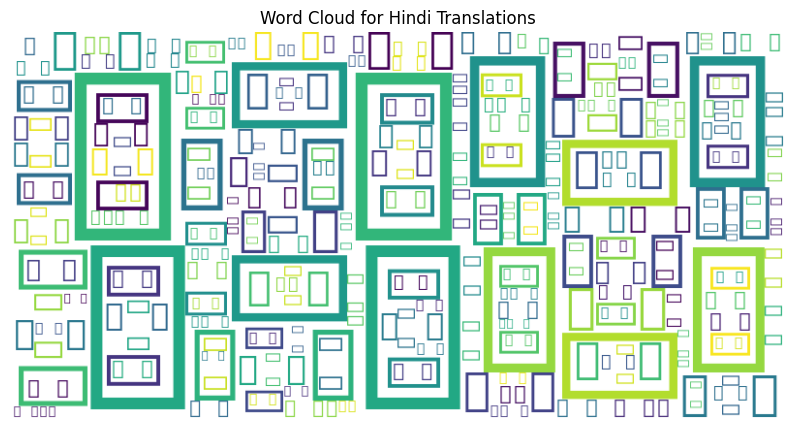

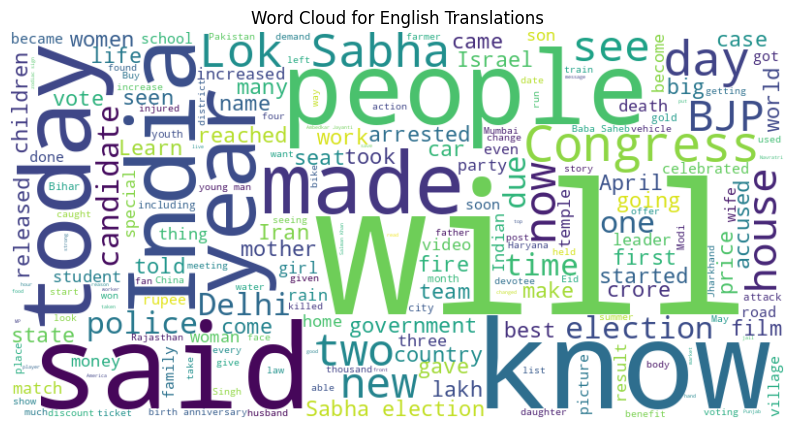

In [6]:
# Word Cloud for Hindi translations
hindi_text = " ".join(df["Hindi"])
wordcloud_hindi = WordCloud(width=800, height=400, background_color='white').generate(hindi_text)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_hindi, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Hindi Translations')
plt.show()

# Word Cloud for English translations
english_text = " ".join(df["English"])
wordcloud_english = WordCloud(width=800, height=400, background_color='white').generate(english_text)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_english, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for English Translations')
plt.show()

### Data Cleaning

In [7]:
# Removing special characters from both english and hindi data
punctuations = set(string.punctuation) # Set of all special characters

# Remove all the special characters
df["Hindi_clean"]=df["Hindi"].apply(lambda x: ''.join(spch for spch in x if spch not in punctuations))
df["English_clean"]=df["English"].apply(lambda x: ''.join(spch for spch in x if spch not in punctuations))

In [8]:
# Removing digits from both english and hindi data
remove_digits = str.maketrans('', '', digits)
df["Hindi_clean"] = df["Hindi_clean"].apply(lambda x: re.sub("[२३०८१५७९४६]", "", x)) # Removing digits in hindi
df["Hindi_clean"] = df["Hindi_clean"].apply(lambda x: x.translate(remove_digits))
df["English_clean"] = df["English_clean"].apply(lambda x: x.translate(remove_digits))

* A list named hindi_stopwords that includes common stopwords in Hindi—words which are typically filtered out before processing natural language data because they are frequent and carry minimal meaningful information by themselves.
* Lowercasing: Converts all characters in the text to lowercase to ensure uniformity.
* URL Replacement: Uses a regular expression to find and replace URLs with a space, removing hyperlinks from the text.
* Tokenization: Breaks the text into individual words or tokens. This requires importing a tokenizer, which is not explicitly imported in the provided code but typically comes from a library like NLTK.
* Stop Words Removal: Removes stopwords from the tokens. Stopwords are commonly used words (like "and", "the", etc.) that are often filtered out before processing text. The code assumes lists of stopwords for both English and Hindi are available.
* Lemmatization: Applies lemmatization to the tokens to reduce them to their base or root form. This part of the code uses the WordNetLemmatizer from the NLTK library.

In [9]:
# Removing stopwords from both english and hindi data
hindi_stopwords = [
    'है', 'में', 'यह', 'वह', 'के', 'हो', 'को', 'पर', 'इस', 'साथ', 'जो', 'कर', 'था', 'द्वारा', 'होता', 'लिए',
    'आप', 'आपको', 'आपका', 'इसे', 'वे', 'उनके', 'बारे', 'तक', 'इन', 'उस', 'अत', 'अब', 'कहा', 'गया', 'जा', 'रहे',
    'उनका', 'इसका', 'रहा', 'जैसे', 'सब', 'किस', 'जिस', 'जिसे', 'किसी', 'किन', 'उसका', 'जिन', 'यदि', 'हुआ', 'जब',
    'कहीं', 'कौन', 'कौनसा', 'इत्यादि', 'यहाँ', 'वहाँ'
]

def preprocess_text(text, lang="en"):
    # Convert text to lowercase
    text = text.lower()
    
    # Replace URLs with a space
    text = re.sub(r'https?://\S+|www\.\S+', ' ', text)
    
    # Tokenization
    tokens = word_tokenize(text)
    
    # Remove English and Hindi stopwords
    eng_stop_words = set(stopwords.words('english'))
    combined_stopwords = eng_stop_words.union(hindi_stopwords)
    
    # Filter out stopwords
    tokens = [word for word in tokens if word not in combined_stopwords]
    
    if lang == "en":
        # Lemmatization
        lemmatizer = WordNetLemmatizer()
        tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    return ' '.join(tokens)

# Apply preprocessing
df['Hindi_clean'] = df['Hindi'].apply(preprocess_text, "hi")
df['English_clean'] = df['English'].apply(preprocess_text, "en")

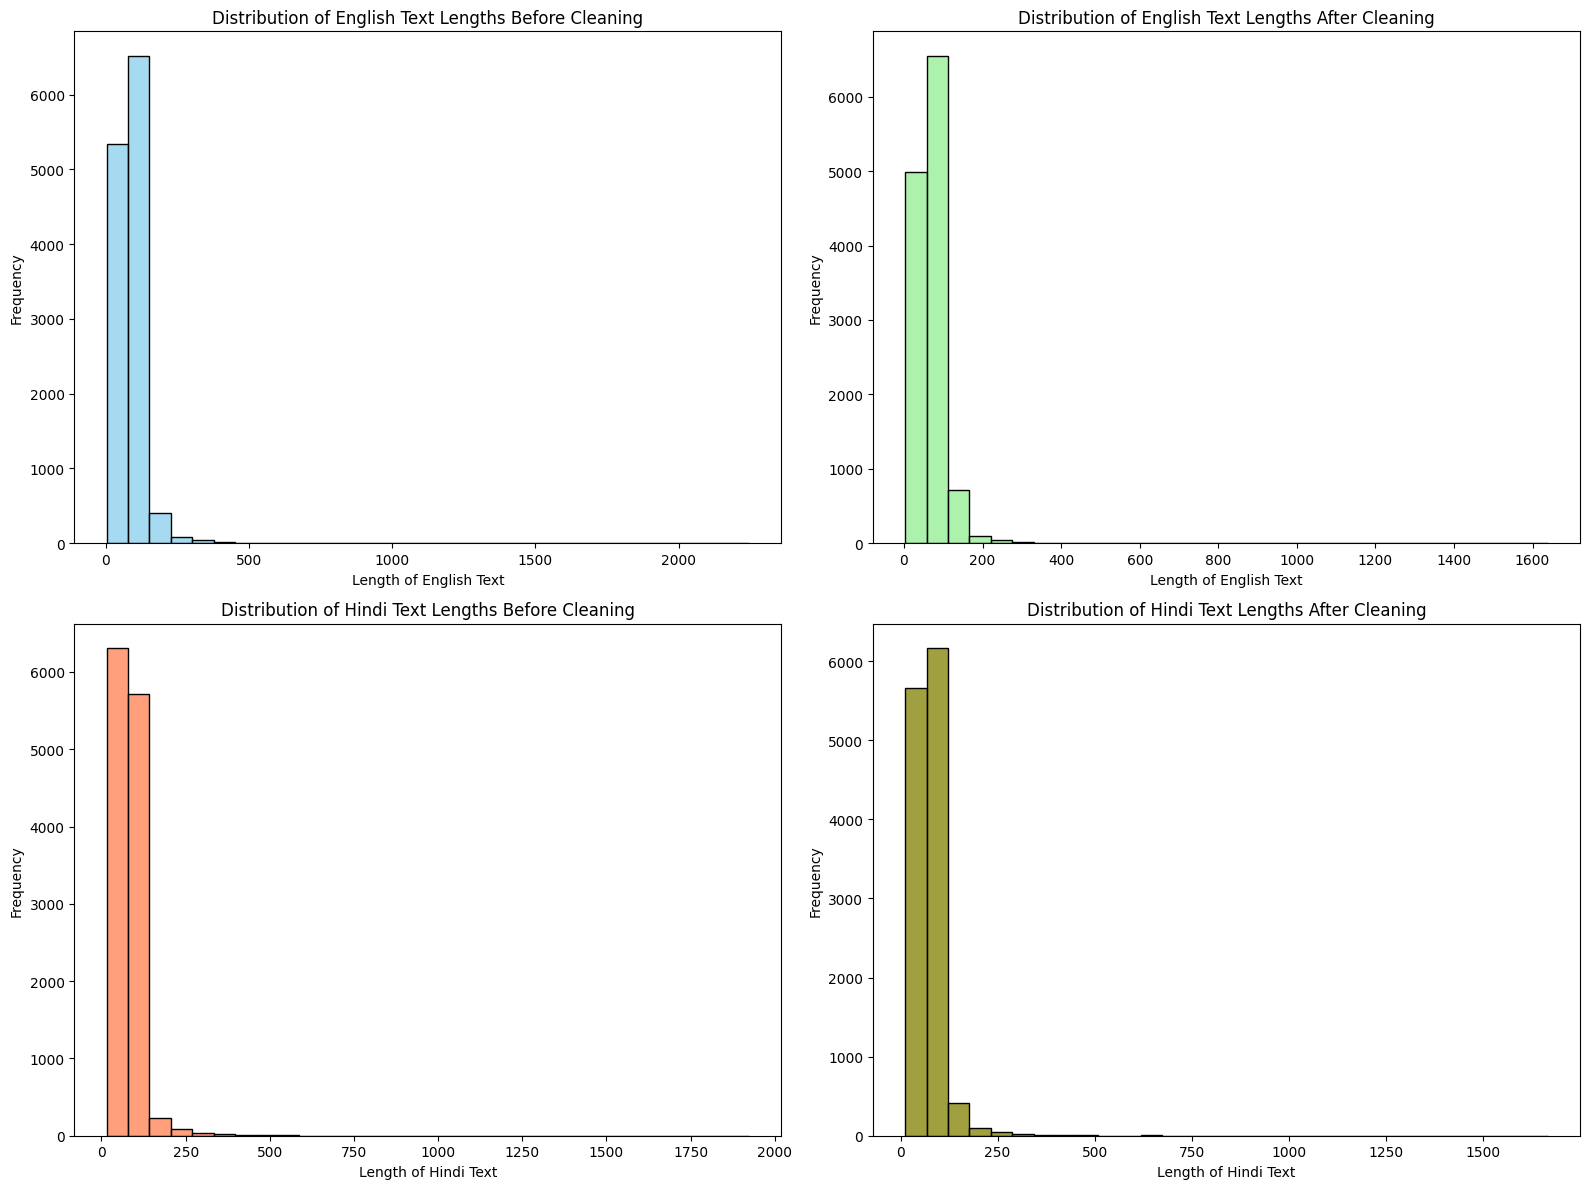

In [10]:
# Visualization of Text Lengths for English and Hindi
fig, ax = plt.subplots(2, 2, figsize=(16, 12))

# English Text Length Distribution Before and After Cleaning
sns.histplot([len(str(x)) for x in df['English']], bins=30, ax=ax[0, 0], color='skyblue')
ax[0, 0].set_title('Distribution of English Text Lengths Before Cleaning')
ax[0, 0].set_xlabel('Length of English Text')
ax[0, 0].set_ylabel('Frequency')

sns.histplot([len(str(x)) for x in df['English_clean']], bins=30, ax=ax[0, 1], color='lightgreen')
ax[0, 1].set_title('Distribution of English Text Lengths After Cleaning')
ax[0, 1].set_xlabel('Length of English Text')
ax[0, 1].set_ylabel('Frequency')

# Hindi Text Length Distribution Before and After Cleaning
sns.histplot([len(str(x)) for x in df['Hindi']], bins=30, ax=ax[1, 0], color='coral')
ax[1, 0].set_title('Distribution of Hindi Text Lengths Before Cleaning')
ax[1, 0].set_xlabel('Length of Hindi Text')
ax[1, 0].set_ylabel('Frequency')

sns.histplot([len(str(x)) for x in df['Hindi_clean']], bins=30, ax=ax[1, 1], color='olive')
ax[1, 1].set_title('Distribution of Hindi Text Lengths After Cleaning')
ax[1, 1].set_xlabel('Length of Hindi Text')
ax[1, 1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [11]:
# Checking for null values
df.isnull().sum()

Reference        0
Hindi            0
English          0
Hindi_clean      0
English_clean    0
dtype: int64

In [12]:
# Removing cells that does not contain data but are not null. 
# Such cells can containt a string as "" which is empty but not null
all_zero_length_indices = df[~((df['Hindi_clean'].str.len() > 0) & (df['English_clean'].str.len() > 0))]
df.drop(all_zero_length_indices.index, inplace=True)
df.reset_index(drop=True, inplace=True)

In [13]:
# Chceking shape of data after final preprocessing
df.shape

(12426, 5)

In [14]:
# Comparing data after final preprocessing 
df.head()

,Reference,Hindi,English,Hindi_clean,English_clean
0,https://www.bhaskar.com/local/mp/indore/,रिहायशी मकान से अलग-अलग ब्रांड की हाईरेंज विदेशी शराब जब्त: इंदौर में दो दिन में अवैध शराब के केस; चुनावी मौसम में सप्लायर सक्रिय,Foreign liquor of different brands from residential houses seized: Illegal liquor cases in two days in Indore;Suppliers active in election season,रिहायशी मकान से अलग-अलग ब्रांड की हाईरेंज विदेशी शराब जब्त : इंदौर दो दिन अवैध शराब केस ; चुनावी मौसम सप्लायर सक्रिय,foreign liquor different brand residential house seized : illegal liquor case two day indore ; supplier active election season
1,https://navbharattimes.indiatimes.com/web-stories/photolist/75432298.cms,जानें क्‍या हैं सब्‍जा सीड्स के फायदे,Learn what are the benefits of vegetable seeds,जानें क्‍या हैं सब्‍जा सीड्स फायदे,learn benefit vegetable seed
2,https://www.jansatta.com/entertainment/krk-urf-kamal-rashid-khan-reaction-on-bollywood-actor-salman-khan-gunshot-outside-bandra-home/3309361/,फिल्म क्रिटिक्स और बॉलीवुड एक्टर कमाल राशिद खान ने हाल ही में ट्वीट करते हुए सलमान खान के घर के बाहर हुई फायरिंग को ड्रामा बताया है।,Film Critics and Bollywood actor Kamal Rashid Khan recently tweeted the firing outside Salman Khan's house as a drama.,फिल्म क्रिटिक्स और बॉलीवुड एक्टर कमाल राशिद खान ने हाल ही ट्वीट करते हुए सलमान खान घर बाहर हुई फायरिंग ड्रामा बताया है।,film critic bollywood actor kamal rashid khan recently tweeted firing outside salman khan 's house drama .
3,https://navbharattimes.indiatimes.com/state/goa/articlelist/92681993.cms,"न्यू ईयर की आतिशबाजी में इटली के राजदूत की पत्नी हुई घायल, गोवा पुलिस ने रिसॉर्ट मालिक के खिलाफ दर्ज की","Italy's wife injured in New Year fireworks, Goa police registered against resort owner","न्यू ईयर की आतिशबाजी इटली राजदूत की पत्नी हुई घायल , गोवा पुलिस ने रिसॉर्ट मालिक खिलाफ दर्ज की","italy 's wife injured new year firework , goa police registered resort owner"
4,https://www.bhaskar.com/local/punjab/,किचन गार्डन के प्रति किया जागरूक,Aware of kitchen garden,किचन गार्डन प्रति किया जागरूक,aware kitchen garden


## Feature Extraction

### Count vectorization:

A straightforward method used in text processing to convert text data into a numerical format, which is essential for machine learning models that require numeric input. Here's a simple explanation of how it works:

Vocabulary Creation: Count vectorization starts by building a vocabulary of all the unique words in the entire set of documents (text data) you have. Each word in the vocabulary is assigned a unique index.

Count Calculation: For each document, the method counts how many times each word from the vocabulary appears. These counts are then organized into a vector (a list of numbers) where each position in the vector corresponds to a word in the vocabulary, and the value at that position is the count of that word in the document.

Document Representation: As a result, each document is transformed into a vector of numbers. These vectors will all be of the same length—the size of the vocabulary. Words that appear in a document have counts greater than zero in the vector at their corresponding index, and words that do not appear have a count of zero.

For more information: [Click here](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)

In [15]:
# Initialize with a maximum feature number limit
vectorizer_bow = CountVectorizer(max_features=1000)

# Fit and transform the data
bow_features = vectorizer_bow.fit_transform(df['Hindi_clean'])

bow_df = pd.DataFrame(bow_features.toarray(), columns=vectorizer_bow.get_feature_names_out())

* Setting a Limit (max_features=1000): We tell the tool to only consider the most frequent 1000 words from all the text we give it. This means if there are more than 1000 unique words across all the texts, only the top 1000 by frequency will be used.

Transforming Text into Numbers (fit_transform):

* Fit: This part of the process is where the tool learns which words are the most common across all the provided Hindi texts. Think of it like making a list of top words.
* Transform: After learning, the tool then goes through each text and counts how many times these top words appear. Each text is transformed into a list of numbers, where each number represents how many times a specific word from the top words list appears in the text.
* Creating a Data Table (DataFrame): The lists of numbers for each text are organized into a table where each column represents one of the top words, and each row represents one of the texts. The numbers in the table tell us the count of each word for each text.

## Word2Vec

Training Data: Word2Vec requires a large amount of text data to learn from. This text data helps the model understand the context in which words appear.

Concept of Context: The model learns by looking at the words that frequently appear around a given word. For instance, in the sentence "I love eating apples", if the model is focusing on the word "eating", the surrounding words like "love" and "apples" give clues about its meaning.

Creating Vectors: Through training, Word2Vec assigns each word in the vocabulary a vector (a list of numbers). These vectors are created in such a way that they capture relationships and patterns among words in the text data. Words with similar meanings end up having vectors that are close to each other in the vector space.

In [16]:
# Tokenize texts for Word2Vec
sentences = [row.split() for row in df['Hindi_clean']]
word2vec_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)

# Convert sentences to vectors
def get_vector(sentence):
    words = sentence.split()
    vector = sum(word2vec_model.wv[word] for word in words if word in word2vec_model.wv) / len(words)
    return vector

X_word2vec = np.array([get_vector(sentence) for sentence in df['Hindi_clean']])

## Model Selection

For the purpose of this assignment we are using a predefined model "Helsinki-NLP/opus-mt-hi-en" from Hugging Face. We will be doing transfer learning on this model to improve performance and accuracy accorrding to our dataset

In [17]:
# Load your model and tokenizer
model_name = "Helsinki-NLP/opus-mt-hi-en"
tokenizer = MarianTokenizer.from_pretrained(model_name)
model = MarianMTModel.from_pretrained(model_name)

#### Split the data into train and validation data

We will be using 75:25 split for the purpose of this project. Since this is a language translation assignment, we do not need a separate test data. We can input text and see the output in real time.

In [18]:
X = df['Hindi_clean']
Y = df['English_clean']
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.25, random_state=42)

Setting machine learning model for sequence-to-sequence training (Transfer Learning):

---

- **Sequence Length Setting**: Defines a maximum token sequence length of `128` for uniformity in processing.
- **Data Tokenization**: 
  - Tokenizes training data (`X_train`) and validation data (`X_val`) using a tokenizer.
  - Encodes inputs to ensure each sequence is padded to or truncated to `128` tokens.
- **Dataset Handling**:
  - Implements a `TranslationDataset` class to manage tokenized encodings and corresponding labels.
  - Creates dataset objects for training and validation using the above class.
- **Training Configuration**:
  - Configures training settings in `Seq2SeqTrainingArguments`:
    - Saves results to `./results`.
    - Evaluates per epoch.
    - Sets learning rate to `3e-5`.
    - Establishes train and eval batch sizes at `8`.
    - Applies a weight decay of `0.01`.
    - Runs for `8` training epochs.
    - Enables predictions during training with `predict_with_generate`.
- **Model Training**:
  - Initializes a `Seq2SeqTrainer` with the model, training arguments, datasets, and tokenizer.
  - Manages and executes the training and evaluation processes.

---

In [19]:
# Set a maximum sequence length for tokens
max_length = 128

# Prepare encodings
train_encodings = tokenizer(X_train.tolist(), return_tensors='pt', padding="max_length", truncation=True, max_length=max_length)
val_encodings = tokenizer(X_val.tolist(), return_tensors='pt', padding="max_length", truncation=True, max_length=max_length)

class TranslationDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# Create Dataset objects
train_dataset = TranslationDataset(train_encodings, tokenizer(Y_train.tolist(), return_tensors='pt', padding="max_length", truncation=True, max_length=max_length)['input_ids'])
val_dataset = TranslationDataset(val_encodings, tokenizer(Y_val.tolist(), return_tensors='pt', padding="max_length", truncation=True, max_length=max_length)['input_ids'])

training_args = Seq2SeqTrainingArguments(
    output_dir='./results',
    evaluation_strategy='epoch',
    learning_rate=3e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    weight_decay=0.01,
    num_train_epochs=50,
    predict_with_generate=True,
)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer
)

#### Retraining the model

In [20]:
trainer.train()

Epoch,Training Loss,Validation Loss
1,0.904800,0.740249
2,0.702900,0.600613
3,0.574300,0.526223
4,0.468300,0.478196
5,0.392300,0.448817
6,0.344400,0.425415
7,0.301700,0.413705
8,0.256900,0.401216
9,0.226100,0.392221
10,0.196100,0.388044


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 512, 'num_beams': 6, 'bad_words_ids': [[61126]], 'forced_eos_token_id': 0}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 512, 'num_beams': 6, 'bad_words_ids': [[61126]], 'forced_eos_token_id': 0}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strate

TrainOutput(global_step=58250, training_loss=0.12533784876156262, metrics={'train_runtime': 8700.9867, 'train_samples_per_second': 53.551, 'train_steps_per_second': 6.695, 'total_flos': 1.57949431382016e+16, 'train_loss': 0.12533784876156262, 'epoch': 50.0})

#### Preprocessing the data same way as training data and make predictions

In [21]:
def translate_batch(texts, model, tokenizer, device, max_length=128):
    encodings = tokenizer(texts, return_tensors="pt", padding=True, truncation=True, max_length=max_length)
    encodings = {key: val.to(device) for key, val in encodings.items()}  # Move encodings to the device

    with torch.no_grad():
        translated_tokens = model.generate(**encodings)
    
    translations = [tokenizer.decode(t, skip_special_tokens=True) for t in translated_tokens.cpu()]  # Move tokens back to CPU for decoding
    return translations

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

sample_df = df[['English', "Hindi_clean"]].sample(5).reset_index(drop=True)
# Batch processing
batch_size = 5
translations = []
for i in range(0, len(sample_df), batch_size):
    batch_texts = sample_df['Hindi_clean'].iloc[i:i+batch_size].tolist()
    batch_translations = translate_batch(batch_texts, model, tokenizer, device)
    translations.extend(batch_translations)


sample_df['predicted_translation'] = translations
sample_df

,English,Hindi_clean,predicted_translation
0,"High court lawyer's house to throw petrol bomb: Attack for second time within four hours, accused also scorched","हाईकोर्ट वकील घर पेट्रोल बम फेंकने का : चार घंटे अंदर दूसरी बार किया हमला , आरोपी भी झुलसा","high court law petrol rapey house : attacked second time inside four hour, accused also scorched"
1,Maneka Gandhi established the Rashtriya Sanjay Manch with Azamgarh politician Akbar Ahmed.,मेनका गांधी ने आज़मगढ़ राजनेता अकबर अहमद राष्ट्रीय संजय मंच की स्थापना की .,maneka gandhi established ahmed national sanjay stage azamadian.
2,But it is overshadowing!Did you spoil the game?Learn the whole matter,भारी पड़ ! क्या ने बिगाड़ दिया खेल ? जानें पूरा मामला,heavy! spoil gamed? learn whole matter
3,": Mount Everest ready to climb Mount Everest for the sake of friend, the trailer video of 'height' releases",": दोस्त की खातिर माउंट एवरेस्ट चढ़ने तैयार जिगरी यार , ' ऊंचाई ' का ट्रेलर वीडियो रिलीज",": mount everest, ready man climbing friend, trailer video 'hind'released"
4,"'Mother is fine, a little swi in', the son was kept in the house for three days, considering the body as alive, know what is the whole matter","' मां ठीक , थोड़ी अकड़ गई ' , शव जिन्दा समझ तीन दिनों से घर रखा बेटा , जानें क्या पूरा मामला","'mamother fixed,'but body understanded body kept son home three day, know whole matter"


#### Saving model's weights and configurations

In [22]:
# Define a GenerationConfig with your custom parameters
gen_config = GenerationConfig(
    max_length=512,
    num_beams=6,
    bad_words_ids=[[61126]],
    forced_eos_token_id=0
)

# Save the model, tokenizer, and generation configuration
save_directory = "./saved_model"
model.save_pretrained(save_directory, gen_config=gen_config)
tokenizer.save_pretrained(save_directory)


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 512, 'num_beams': 6, 'bad_words_ids': [[61126]], 'forced_eos_token_id': 0}


('./saved_model/tokenizer_config.json',
 './saved_model/special_tokens_map.json',
 './saved_model/vocab.json',
 './saved_model/source.spm',
 './saved_model/target.spm',
 './saved_model/added_tokens.json')